### Learning to rank with XGB - basic example

- based on small subset
- amenities not merged
- only left integer/float variables, no feature pre-processing
- click and transaction in one relevance label (click weight: 1, transaction weight: 2)



code folllows this example https://www.kaggle.com/code/azimuthal01/learning-to-rank

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/expedia/exploded_df.csv")

In [17]:
df.head()

,user_id,search_id,search_timestamp,point_of_sale,geo_location_country,is_mobile,destination_id,checkin_date,checkout_date,adult_count,...,prop_id,is_travel_ad,review_rating,review_count,star_rating,is_free_cancellation,is_drr,price_bucket,num_clicks,is_trans
0,001bbff3030c95740d4c55bb72e823e9,541933a931216d270f53277c2de068d0,2021-07-02T19:38:00.000Z,2,1,0,898,2021-07-04,2021-07-05,2,...,5695234,1,4.0,250.0,2.0,1,0,3.0,0,0
1,001bbff3030c95740d4c55bb72e823e9,541933a931216d270f53277c2de068d0,2021-07-02T19:38:00.000Z,2,1,0,898,2021-07-04,2021-07-05,2,...,1734546,1,4.0,1000.0,2.0,1,0,4.0,0,0
2,001bbff3030c95740d4c55bb72e823e9,541933a931216d270f53277c2de068d0,2021-07-02T19:38:00.000Z,2,1,0,898,2021-07-04,2021-07-05,2,...,5675938,0,5.0,700.0,3.0,1,0,3.0,0,0
3,001bbff3030c95740d4c55bb72e823e9,541933a931216d270f53277c2de068d0,2021-07-02T19:38:00.000Z,2,1,0,898,2021-07-04,2021-07-05,2,...,5695234,0,4.0,250.0,2.0,1,0,3.0,0,0
4,001bbff3030c95740d4c55bb72e823e9,541933a931216d270f53277c2de068d0,2021-07-02T19:38:00.000Z,2,1,0,898,2021-07-04,2021-07-05,2,...,2012023,0,4.0,625.0,2.0,0,0,1.0,0,0


In [18]:
# create integer query ID

group_map = {}
counter = 1
for group in df['search_id'].unique():
    group_map[group] = counter
    counter += 1

# Apply the mapping to create a new column with integer identifiers
df['qid'] = df['search_id'].map(group_map)

df.head()

,user_id,search_id,search_timestamp,point_of_sale,geo_location_country,is_mobile,destination_id,checkin_date,checkout_date,adult_count,...,is_travel_ad,review_rating,review_count,star_rating,is_free_cancellation,is_drr,price_bucket,num_clicks,is_trans,qid
0,001bbff3030c95740d4c55bb72e823e9,541933a931216d270f53277c2de068d0,2021-07-02T19:38:00.000Z,2,1,0,898,2021-07-04,2021-07-05,2,...,1,4.0,250.0,2.0,1,0,3.0,0,0,1
1,001bbff3030c95740d4c55bb72e823e9,541933a931216d270f53277c2de068d0,2021-07-02T19:38:00.000Z,2,1,0,898,2021-07-04,2021-07-05,2,...,1,4.0,1000.0,2.0,1,0,4.0,0,0,1
2,001bbff3030c95740d4c55bb72e823e9,541933a931216d270f53277c2de068d0,2021-07-02T19:38:00.000Z,2,1,0,898,2021-07-04,2021-07-05,2,...,0,5.0,700.0,3.0,1,0,3.0,0,0,1
3,001bbff3030c95740d4c55bb72e823e9,541933a931216d270f53277c2de068d0,2021-07-02T19:38:00.000Z,2,1,0,898,2021-07-04,2021-07-05,2,...,0,4.0,250.0,2.0,1,0,3.0,0,0,1
4,001bbff3030c95740d4c55bb72e823e9,541933a931216d270f53277c2de068d0,2021-07-02T19:38:00.000Z,2,1,0,898,2021-07-04,2021-07-05,2,...,0,4.0,625.0,2.0,0,0,1.0,0,0,1


In [19]:
# how many queries in test data?
len(df["qid"].unique())

997

In [20]:
### create relevance label
# 1 for clicked on
# 2 for transaction

df['relevance'] = 0  # Initialize with default value
df.loc[df['num_clicks'] > 0, 'relevance'] = 1  # Set value to 1 if first_column > 0
df.loc[df['is_trans'] > 0, 'relevance'] = 2  # Add 2 if second_column > 0

df.head(10)

,user_id,search_id,search_timestamp,point_of_sale,geo_location_country,is_mobile,destination_id,checkin_date,checkout_date,adult_count,...,review_rating,review_count,star_rating,is_free_cancellation,is_drr,price_bucket,num_clicks,is_trans,qid,relevance
0,001bbff3030c95740d4c55bb72e823e9,541933a931216d270f53277c2de068d0,2021-07-02T19:38:00.000Z,2,1,0,898,2021-07-04,2021-07-05,2,...,4.0,250.0,2.0,1,0,3.0,0,0,1,0
1,001bbff3030c95740d4c55bb72e823e9,541933a931216d270f53277c2de068d0,2021-07-02T19:38:00.000Z,2,1,0,898,2021-07-04,2021-07-05,2,...,4.0,1000.0,2.0,1,0,4.0,0,0,1,0
2,001bbff3030c95740d4c55bb72e823e9,541933a931216d270f53277c2de068d0,2021-07-02T19:38:00.000Z,2,1,0,898,2021-07-04,2021-07-05,2,...,5.0,700.0,3.0,1,0,3.0,0,0,1,0
3,001bbff3030c95740d4c55bb72e823e9,541933a931216d270f53277c2de068d0,2021-07-02T19:38:00.000Z,2,1,0,898,2021-07-04,2021-07-05,2,...,4.0,250.0,2.0,1,0,3.0,0,0,1,0
4,001bbff3030c95740d4c55bb72e823e9,541933a931216d270f53277c2de068d0,2021-07-02T19:38:00.000Z,2,1,0,898,2021-07-04,2021-07-05,2,...,4.0,625.0,2.0,0,0,1.0,0,0,1,0
5,001bbff3030c95740d4c55bb72e823e9,541933a931216d270f53277c2de068d0,2021-07-02T19:38:00.000Z,2,1,0,898,2021-07-04,2021-07-05,2,...,5.0,525.0,3.0,1,0,5.0,0,0,1,0
6,001bbff3030c95740d4c55bb72e823e9,541933a931216d270f53277c2de068d0,2021-07-02T19:38:00.000Z,2,1,0,898,2021-07-04,2021-07-05,2,...,4.0,75.0,3.0,1,1,2.0,1,0,1,1
7,001bbff3030c95740d4c55bb72e823e9,541933a931216d270f53277c2de068d0,2021-07-02T19:38:00.000Z,2,1,0,898,2021-07-04,2021-07-05,2,...,4.0,1000.0,2.0,1,0,4.0,0,0,1,0
8,001bbff3030c95740d4c55bb72e823e9,541933a931216d270f53277c2de068d0,2021-07-02T19:38:00.000Z,2,1,0,898,2021-07-04,2021-07-05,2,...,4.0,250.0,3.0,1,0,2.0,1,0,1,1
9,001bbff3030c95740d4c55bb72e823e9,541933a931216d270f53277c2de068d0,2021-07-02T19:38:00.000Z,2,1,0,898,2021-07-04,2021-07-05,2,...,4.0,575.0,2.0,1,1,4.0,0,0,1,0


In [21]:
#### barplot of relevance labels
import matplotlib.pyplot as plt

frequency_counts = df['relevance'].value_counts()



In [22]:
frequency_counts[1]/frequency_counts[0]

0.006403188872869138

<BarContainer object of 3 artists>

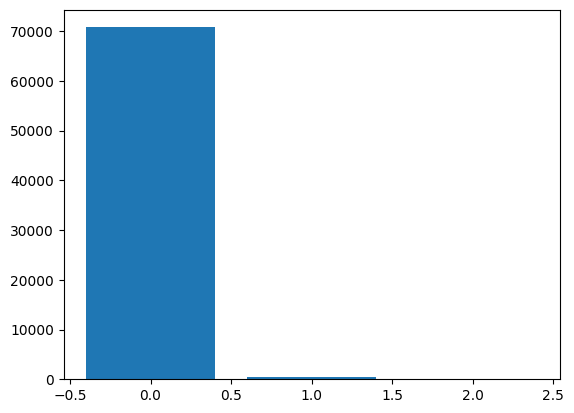

In [23]:
### here we can see the extreme sparsity in relevance column
plt.bar(frequency_counts.index, frequency_counts.values)

In [24]:
df.relevance.mean()

0.009381968109722747

In [25]:
## keep only integer/float columns for XGB

df_model = df.drop(labels = ["user_id", "search_id", "search_timestamp",
                             "checkin_date", "checkout_date", "num_clicks",
                             "is_trans", "sort_type", "applied_filters", "rank"],
                    axis=1)

# if i exclude the initial rank from the data - do i ignore the potential effect
#  on relevance (clicks) the initial ranking has on the relevance proxies?

df_model.head()

,point_of_sale,geo_location_country,is_mobile,destination_id,adult_count,child_count,infant_count,room_count,prop_id,is_travel_ad,review_rating,review_count,star_rating,is_free_cancellation,is_drr,price_bucket,qid,relevance
0,2,1,0,898,2,0,0,1,5695234,1,4.0,250.0,2.0,1,0,3.0,1,0
1,2,1,0,898,2,0,0,1,1734546,1,4.0,1000.0,2.0,1,0,4.0,1,0
2,2,1,0,898,2,0,0,1,5675938,0,5.0,700.0,3.0,1,0,3.0,1,0
3,2,1,0,898,2,0,0,1,5695234,0,4.0,250.0,2.0,1,0,3.0,1,0
4,2,1,0,898,2,0,0,1,2012023,0,4.0,625.0,2.0,0,0,1.0,1,0


In [27]:
df_model.shape

(71307, 18)

In [28]:
# drop rows with NaN values

df_model = df_model.dropna()

# we lose ~40% of the data, too much
df_model.shape

(44384, 18)

In [29]:
# separate train and test by qid, so same queries stay together

train_df = df_model[df_model["qid"] >= 200]
train_df.shape

(35801, 18)

In [30]:
test_df = train_df = df_model[df_model["qid"] < 200]
test_df.shape

(8583, 18)

In [32]:
from sklearn.preprocessing import normalize


X = train_df[train_df.columns[0:16]]
# normalize X
X = normalize(X)

y = train_df["relevance"]

In [34]:
X[0:5]

array([[3.51170816e-07, 1.75585408e-07, 0.00000000e+00, 1.57675697e-04,
        3.51170816e-07, 0.00000000e+00, 0.00000000e+00, 1.75585408e-07,
        9.99999987e-01, 1.75585408e-07, 7.02341633e-07, 4.38963520e-05,
        3.51170816e-07, 1.75585408e-07, 0.00000000e+00, 5.26756225e-07],
       [1.15303912e-06, 5.76519562e-07, 0.00000000e+00, 5.17714566e-04,
        1.15303912e-06, 0.00000000e+00, 0.00000000e+00, 5.76519562e-07,
        9.99999700e-01, 5.76519562e-07, 2.30607825e-06, 5.76519562e-04,
        1.15303912e-06, 5.76519562e-07, 0.00000000e+00, 2.30607825e-06],
       [3.52364659e-07, 1.76182330e-07, 0.00000000e+00, 1.58211732e-04,
        3.52364659e-07, 0.00000000e+00, 0.00000000e+00, 1.76182330e-07,
        9.99999980e-01, 0.00000000e+00, 8.80911648e-07, 1.23327631e-04,
        5.28546989e-07, 1.76182330e-07, 0.00000000e+00, 5.28546989e-07],
       [3.51170816e-07, 1.75585408e-07, 0.00000000e+00, 1.57675697e-04,
        3.51170816e-07, 0.00000000e+00, 0.00000000e+00, 1.755

In [35]:
X_test = test_df[train_df.columns[0:16]]

y_test = test_df["relevance"]

In [36]:
g = train_df.groupby(by="qid")
size = g.size()
group_train = size.to_list()

g = test_df.groupby(by="qid")
size = g.size()
group_valid = size.to_list()

In [37]:
import xgboost as xgb

In [38]:
ranker = xgb.XGBRanker(
        n_estimators=1000,
        learning_rate=0.1,
        objective='rank:ndcg', # in allRank paper, they use rank:pairwise
        lambdarank_num_pair_per_sample=8,
        lambdarank_pair_method="topk",
        reg_lambda=0.05,
        # verbose = True,
        tree_method = 'hist',
        device = 'cuda'
    )

ranker.fit(
    X.astype(float),
    y.astype(int),
    group=group_train,
    eval_group=[group_valid],
    eval_set=[(X_test.astype(float), y_test.astype(int))],
    #early_stopping_rounds=100,
    verbose = True
)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-ndcg@8:0.91272
[1]	validation_0-ndcg@8:0.95336
[2]	validation_0-ndcg@8:0.95918
[3]	validation_0-ndcg@8:0.96725
[4]	validation_0-ndcg@8:0.96809
[5]	validation_0-ndcg@8:0.96940
[6]	validation_0-ndcg@8:0.97154
[7]	validation_0-ndcg@8:0.97508
[8]	validation_0-ndcg@8:0.97508
[9]	validation_0-ndcg@8:0.97691
[10]	validation_0-ndcg@8:0.97837
[11]	validation_0-ndcg@8:0.97837
[12]	validation_0-ndcg@8:0.97954
[13]	validation_0-ndcg@8:0.97954
[14]	validation_0-ndcg@8:0.97978
[15]	validation_0-ndcg@8:0.97985
[16]	validation_0-ndcg@8:0.97985
[17]	validation_0-ndcg@8:0.97985
[18]	validation_0-ndcg@8:0.97985
[19]	validation_0-ndcg@8:0.98200
[20]	validation_0-ndcg@8:0.98200
[21]	validation_0-ndcg@8:0.98200
[22]	validation_0-ndcg@8:0.98282
[23]	validation_0-ndcg@8:0.98282
[24]	validation_0-ndcg@8:0.98282
[25]	validation_0-ndcg@8:0.98282
[26]	validation_0-ndcg@8:0.98282
[27]	validation_0-ndcg@8:0.98282
[28]	validation_0-ndcg@8:0.98282
[29]	validation_0-ndcg@8:0.98282
[30]	validation_0-nd

XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device='cuda',
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
          importance_type=None, interaction_constraints=None,
          lambdarank_num_pair_per_sample=8, lambdarank_pair_method='topk',
          learning_rate=0.1, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=1000,
          n_jobs=None, ...)

In [39]:
test_pred = ranker.predict(X_test.astype(float))
y_test_df = pd.DataFrame({"relevance_score": y_test, "predicted_ranking": test_pred})

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [10:52:17] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [ ]:
type(y_test_df)

pandas.core.frame.DataFrame

In [41]:
## here we have relevance label and predicted ranking score, not ordered yet

y_test_df.head(20)

,relevance_score,predicted_ranking
0,0,-3.247567
1,0,-3.605859
2,0,-4.365658
3,0,-3.247567
4,0,-2.344188
5,0,-3.680912
6,1,1.662432
7,0,-3.605859
8,1,0.970623
9,0,-1.657574


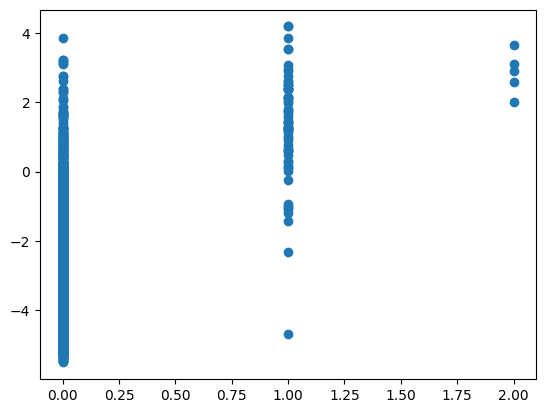

In [42]:
### scatter plot of relevance and score
# we expect a higher predicted ranking vor values 1 and 2 on x - axis
plt.scatter(y_test_df["relevance_score"], y_test_df["predicted_ranking"])

y_test_df.shape # can this plot be made for a specific search

In [43]:
true_relevance = y_test.sort_values(ascending=False)

# Sort the relevance scores from most relevant to least relevant
# does it sort them by group (meaning by query)
relevance_score = y_test_df.sort_values("predicted_ranking", ascending=False)

In [44]:
true_relevance

13110    2
3698     2
4061     2
7593     2
8733     2
        ..
6266     0
6268     0
6269     0
6270     0
6261     0
Name: relevance, Length: 8583, dtype: int64

In [45]:
relevance_score

,relevance_score,predicted_ranking
10441,1,4.188968
10541,1,4.188968
9722,0,3.845100
9822,1,3.845100
8733,2,3.665671
...,...,...
10010,0,-5.431839
14524,0,-5.460176
9537,0,-5.460809
14406,0,-5.465255


In [46]:
import numpy as np
from sklearn.metrics import ndcg_score

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ndcg_score.html
"This ranking metric returns a high value if true labels are ranked high by y_score."
--> is the grouping value required for the calculation of the NDCG?

In [47]:
print(
        "nDCG score: ",
        ndcg_score(
            [true_relevance.to_numpy()], [relevance_score["relevance_score"].to_numpy()]
        ),
    )

print(
        "nDCG score @ 5: ",
        ndcg_score(
            y_true = [true_relevance.to_numpy()], y_score = [relevance_score["relevance_score"].to_numpy()], k=5
        ),
    )

print(
        "nDCG score @ 10: ",
        ndcg_score(
            y_true = [true_relevance.to_numpy()], y_score = [relevance_score["relevance_score"].to_numpy()], k=10
        ),
    )

print(
        "nDCG score @ 50: ",
        ndcg_score(
            y_true = [true_relevance.to_numpy()], y_score = [relevance_score["relevance_score"].to_numpy()], k=50
        ),
    )

nDCG score:  0.7238262521467492
nDCG score @ 5:  0.6
nDCG score @ 10:  0.5930090368291014
nDCG score @ 50:  0.57938352828824


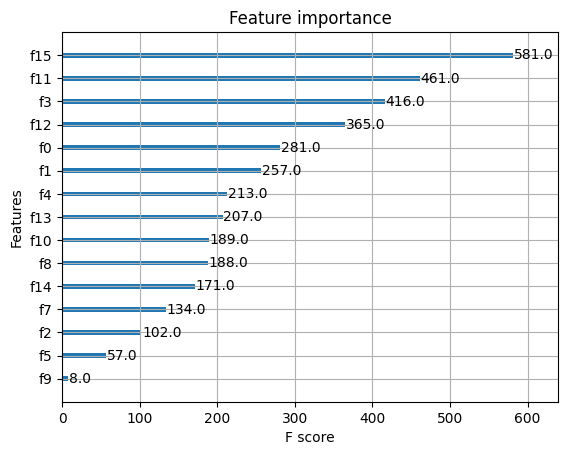

In [49]:
#### show feature importance
from xgboost import plot_importance
# from matplotlib import pyplot

plot_importance(ranker)
plt.show()

# include label names


In [50]:
# list of features
features_list = df_model.columns.tolist()

print(features_list)

['point_of_sale', 'geo_location_country', 'is_mobile', 'destination_id', 'adult_count', 'child_count', 'infant_count', 'room_count', 'prop_id', 'is_travel_ad', 'review_rating', 'review_count', 'star_rating', 'is_free_cancellation', 'is_drr', 'price_bucket', 'qid', 'relevance']


Possible next steps:
- build it as a proper pipeline (similar to supervised classification)
- feature preprocessing (start with normalization) -> is it done correctly?
- include more features
- compare to initial ranks
- parameter that handles initial position bias
- separate models: only clicks and only transactions in relevance label
- position debiasing